In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import ast
import geoip2.database

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import pipeline
import gc

from scipy.special import softmax

# loading data
cc_codes = ["uk", "de", "pl", "es", "ru", "en"]
filename_pattern_test = "../data/multilingual_train/test_full_week_{}_non_anon_processed.csv".format("_".join(cc_codes))
test_df = pd.read_csv(filename_pattern_test)

In [2]:
test_df.head()

,wiki_db,event_comment,event_user_text_historical,event_user_seconds_since_previous_revision,revision_id,page_title,page_revision_count,revision_text_bytes_diff,revision_is_identity_reverted,event_timestamp,...,change_s_0_mean,change_s_1_mean,change_p_0_mean,change_p_1_mean,title_s_0,title_p_0,comment_s_0,comment_s_1,comment_p_0,comment_p_1
0,ukwiki,вилучив додаткові пробіли,HutheMeow,575.0,36399189,Grand_Theft_Auto:_Liberty_City_Stories,63,-2,0,2022-07-01 01:55:08.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.782928,1.0,0.014682,-0.198847,0.55318,0.44682
1,ukwiki,[[Help:Cat-a-lot|Cat-a-lot]]: Removing from [[...,Mr.Rosewater,0.0,36399416,Елізабет_Філпот,7,-62,0,2022-07-01 03:52:18.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.293543,1.0,0.014682,-0.198847,0.55318,0.44682
2,ukwiki,додано [[Категорія:Убиті на дуелі]] за допомог...,Mr.Rosewater,445.0,36399659,Еварист_Галуа,140,50,0,2022-07-01 04:35:09.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.076811,1.0,0.014682,-0.198847,0.55318,0.44682
3,ukwiki,"Уточнення щодо розташування, та додаткова інфо...",Ostwik,133803613.0,36400077,Парк_«Чонок»,5,284,0,2022-07-01 05:31:15.0,...,2.511288,-2.375829,0.992513,0.007487,0.836785,1.0,0.014682,-0.198847,0.55318,0.44682
4,ukwiki,NaN,Вальдимар,60.0,36400917,Кабалуд,22,-447,0,2022-07-01 07:44:57.0,...,1.986099,-1.732105,0.976298,0.023702,0.192396,1.0,-1.000000,-1.000000,-1.00000,-1.00000


In [3]:
test_df.wiki_db.value_counts()

enwiki    695938
dewiki    108282
eswiki     92159
ruwiki     83236
plwiki     28168
ukwiki     28024
Name: wiki_db, dtype: int64

In [4]:
len(test_df)

1035807

In [5]:
feat = ['Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove']
features_actions = ["_".join([old.split("_")[1], old.split("_")[0]]) for old in feat]

features_list = [
       'wiki_db',
       # 'page_title', 
       # 'page_revision_count', 
       'revision_text_bytes_diff',
       'is_mobile_edit', 'is_mobile_web_edit',
       'is_visualeditor', 'is_wikieditor',
       'is_ios_app_edit',
       # 'texts_removed', 'texts_insert', 'texts_change', 'actions',
       # 'categories', 'wikidata_item_id', 
       # 'page_region', 'country_iso_code',
       # 'region_iso_code', 'city', 'latitude', 'longitude',
] + features_actions\
+ [f"bert_insert_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]] \
+ [f"bert_change_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]] \
+ [f"bert_comment_{c}" for c in ["s0", "s1", "p0", "p1"]] \
+ ["bert_title_score"]

target_column = 'revision_is_identity_reverted'
features = features_list
cat_features = [
    'wiki_db',
    # 'page_title', 
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_ios_app_edit',
    # 'page_region', 'country_iso_code',
    # 'region_iso_code', 'city'
]

In [6]:
# renaming for convention:

features_renaming = dict()

old_insert = [f"insert_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
new_insert = [f"bert_insert_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})

old_insert = [f"change_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
new_insert = [f"bert_change_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})

old_insert = [f"comment_{c}" for c in ["s_0", "s_1", "p_0", "p_1"]]
new_insert = [f"bert_comment_{c}" for c in ["s0", "s1", "p0", "p1"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})

feat = ['Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove']

features_renaming.update({old: "_".join([old.split("_")[1], old.split("_")[0]]) for old in feat})

new_columns = [features_renaming.get(x, x) for x in test_df.columns]
test_df.columns = new_columns

In [7]:
model_path = "../title_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-19270"
tokenizer = AutoTokenizer.from_pretrained(
    model_path, truncation=True, max_length=512, device="gpu"
)
model = BertForSequenceClassification.from_pretrained(model_path).to("cuda")
pipe = pipeline(
    task="text-classification", model=model, tokenizer=tokenizer, batch_size=1, device=0
)

test_df.page_title = test_df.page_title.apply(lambda x: str(x).replace("_", " "))

text_to_process = test_df.page_title.unique()
text_features_inter = pipe(
        list(text_to_process),
        return_all_scores=True,
        function_to_apply="none",
        truncation=True,
        max_length=512,
        batch_size=1000,
)
text_features = {text: a[0]['score'] for text, a in zip(text_to_process, text_features_inter)}
test_df["bert_title_score"] = test_df.page_title.apply(lambda x: text_features[x])

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


# Modeling:

In [8]:
model = CatBoostClassifier().load_model("classifier")

# 3. Compare performance with Diego's model and ORES

In [9]:
diegos_model_res = pd.read_csv("../data/multilingual_train/test_xgb_proba_full_non_anon.csv")
ores_model_res = pd.read_csv("../data/multilingual_train/test_full_ores_res_non_anon.csv")

diegos_model_res_dict = {rid: score for rid, score in zip(diegos_model_res.revision_id, diegos_model_res.xgb_pred_proba)}
ores_model_res_dict = {rid: score for rid, score in zip(ores_model_res.revision_id, ores_model_res.ores_pred)}

In [10]:
hold_out_data = Pool(
    data=test_df[features_list].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

test_df["catboost_pred"] = model.predict_proba(hold_out_data)[:, 1]
test_df["ores_pred"] = test_df.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
test_df["xgb_pred"] = test_df.revision_id.apply(lambda x: diegos_model_res_dict.get(x)).fillna(-1)

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

threshold = 0.5

df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
# df_to_plot = test_df
print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.8071623767213215
Xgboost model accuracy:  0.7353146977700427
ORES model accuracy:  0.8929103945935493
--------------------------------------------------
Catboost model AUC:  0.7888392575533782
Xgboost model AUC:  0.8514391693012682
ORES model AUC:  0.8271284430678704
--------------------------------------------------
Catboost model F1:  0.3334344780274146
Xgboost model F1:  0.3349731334886828
ORES model F1:  0.39505551762549856


# Building a full meta-model:

In [17]:
### Adding xgb features (we have only part of features, so the experiment is highly reduced)

import pandas as pd
import ast

data_res = pd.read_csv("../data/test_part_1_xgb_res.csv")
data_res.xgb_pred = data_res.xgb_pred.apply(ast.literal_eval)

data_res.index = data_res.revision_id
data_res_dict = data_res["xgb_pred"].to_dict()

In [43]:
default_features = {
    'user_groups': None,
    'page_seconds_since_previous_revision': None,
    'user_revision_count': None,
    'user_age': None,
    'page_age': None,
     'user_is_anonymous': None,
     'revision_text_bytes': None,
     'revision_text_bytes_diff': None,
     'has_comment': None,
     'quality_score': None,
     'parent_quality_score': None,
     'quality_change': None,
     'quality_change_range': None,
     'quality_range': None,
     'text_length': None,
     'parent_text_length': None,
     'reference_count': None,
     'parent_reference_count': None,
     'wikilink_count': None,
     'parent_wikilink_count': None,
     'category_count': None,
     'parent_category_count': None,
     'media_count': None,
     'parent_media_count': None,
     'heading_count': None,
     'parent_heading_count': None
}
additional_features = [data_res_dict.get(i, {}).get('features', default_features) 
                       if data_res_dict.get(i, {}).get('features', default_features) is not None
                       else default_features
                       for i in test_df.revision_id]

In [46]:
additional_features = pd.DataFrame(additional_features)

In [50]:
# rate of features that are missed
additional_features.isna().mean().mean()

0.6364602672119422

In [86]:
full_features_dataset = pd.concat([test_df, additional_features], axis=1)
full_features_dataset.dropna(subset=["user_groups"], inplace=True)

full_features_dataset = full_features_dataset.loc[:,~full_features_dataset.columns.duplicated()].copy()

In [79]:
additional_features_names = additional_features.columns

In [82]:
additional_features_names

Index(['user_groups', 'page_seconds_since_previous_revision',
       'user_revision_count', 'user_age', 'page_age', 'user_is_anonymous',
       'revision_text_bytes', 'revision_text_bytes_diff', 'has_comment',
       'quality_score', 'parent_quality_score', 'quality_change',
       'quality_change_range', 'quality_range', 'text_length',
       'parent_text_length', 'reference_count', 'parent_reference_count',
       'wikilink_count', 'parent_wikilink_count', 'category_count',
       'parent_category_count', 'media_count', 'parent_media_count',
       'heading_count', 'parent_heading_count'],
      dtype='object')

# Building reduced META model: 

In [80]:
features_to_use = features_list + ["xgb_pred", "catboost_pred"]
target = 'revision_is_identity_reverted'

In [81]:
BALANCE_DATASET = False
BALANCE_CLASS_MODEL = True
features = features_to_use

# df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1)]

df_to_plot = full_features_dataset.copy()
df_to_plot["day"] = pd.to_datetime(df_to_plot.event_timestamp).dt.day
train, test = df_to_plot[df_to_plot.day.isin([1, 2, 3, 4, 5])], df_to_plot[df_to_plot.day.isin([6, 7])]

cat_features = [
    'wiki_db',
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_ios_app_edit'
]

train_data = Pool(
    data=train[features],
    label=train[target],
    cat_features=cat_features
)
test_data = Pool(
    data=test[features],
    label=test[target],
    cat_features=cat_features
)

### class weighting
if BALANCE_CLASS_MODEL:
    classes = np.unique(train[target])
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=train[target])
    class_weights = dict(zip(classes, weights))
else:
    class_weights = {0: 1, 1: 1}
#####


# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=5000, metric_period=100, verbose=True, learning_rate=0.01, class_weights=class_weights, 
                           use_best_model=True,
                           custom_metric=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])
# Fit model
model.fit(train_data, eval_set=test_data, plot=False)

# baseline score -> not training :)
model.best_score_

0:	learn: 0.6879545	test: 0.6877732	best: 0.6877732 (0)	total: 139ms	remaining: 11m 35s
100:	learn: 0.4630361	test: 0.4549942	best: 0.4549942 (100)	total: 7.06s	remaining: 5m 42s
200:	learn: 0.4282335	test: 0.4225956	best: 0.4225956 (200)	total: 14s	remaining: 5m 34s
300:	learn: 0.4178558	test: 0.4143676	best: 0.4143676 (300)	total: 20.9s	remaining: 5m 26s
400:	learn: 0.4131788	test: 0.4113466	best: 0.4113466 (400)	total: 27.7s	remaining: 5m 18s
500:	learn: 0.4100494	test: 0.4099788	best: 0.4099788 (500)	total: 34.5s	remaining: 5m 9s
600:	learn: 0.4078111	test: 0.4091070	best: 0.4091070 (600)	total: 41.2s	remaining: 5m 1s
700:	learn: 0.4060838	test: 0.4086475	best: 0.4086475 (700)	total: 47.6s	remaining: 4m 52s
800:	learn: 0.4045833	test: 0.4082020	best: 0.4082020 (800)	total: 54.1s	remaining: 4m 43s
900:	learn: 0.4034467	test: 0.4079932	best: 0.4079932 (900)	total: 1m	remaining: 4m 35s
1000:	learn: 0.4022991	test: 0.4077066	best: 0.4077066 (1000)	total: 1m 7s	remaining: 4m 28s
1100:	l

{'learn': {'Accuracy:use_weights=false': 0.8341935435682167,
  'Precision:use_weights=false': 0.30309257512464627,
  'Recall:use_weights=false': 0.8561640576676024,
  'Logloss:use_weights=true': 0.3612968923370384,
  'Accuracy:use_weights=true': 0.8442431165274036,
  'Logloss:use_weights=false': 0.3688343392104331,
  'Logloss': 0.3612968923370384,
  'Precision:use_weights=true': 0.836226827680904,
  'Recall:use_weights=true': 0.8561640576676024,
  'F1:use_weights=false': 0.447695465571935,
  'F1:use_weights=true': 0.8460780072924557},
 'validation': {'Accuracy:use_weights=false': 0.8280587905471859,
  'Recall:use_weights=false': 0.8565764132774442,
  'Precision:use_weights=false': 0.2956773526370217,
  'Logloss:use_weights=true': 0.4065093003763084,
  'Accuracy:use_weights=true': 0.8211607729093003,
  'AUC': 0.8966459307618085,
  'Logloss:use_weights=false': 0.37861622700362585,
  'Logloss': 0.4065093003763084,
  'Precision:use_weights=true': 0.8313273939626099,
  'Recall:use_weights=t

### Full META model with additional features

In [90]:
additional_features_names = list(additional_features_names)
additional_features_names.remove("revision_text_bytes_diff")
features_to_use = features_list + ["xgb_pred", "catboost_pred"] + additional_features_names
target = 'revision_is_identity_reverted'

BALANCE_DATASET = False
BALANCE_CLASS_MODEL = True
features = features_to_use

df_to_plot = full_features_dataset.copy()
df_to_plot["day"] = pd.to_datetime(df_to_plot.event_timestamp).dt.day
train, test = df_to_plot[df_to_plot.day.isin([1, 2, 3, 4, 5])], df_to_plot[df_to_plot.day.isin([6, 7])]

cat_features = [
    'wiki_db',
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_ios_app_edit'
]

train_data = Pool(
    data=train[features],
    label=train[target],
    cat_features=cat_features
)
test_data = Pool(
    data=test[features],
    label=test[target],
    cat_features=cat_features
)

### class weighting
if BALANCE_CLASS_MODEL:
    classes = np.unique(train[target])
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=train[target])
    class_weights = dict(zip(classes, weights))
else:
    class_weights = {0: 1, 1: 1}
#####


# Initialize CatBoostClassifier
model_full = CatBoostClassifier(iterations=5000, metric_period=100, verbose=True, learning_rate=0.01, class_weights=class_weights, 
                           use_best_model=True,
                           custom_metric=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])
# Fit model
model_full.fit(train_data, eval_set=test_data, plot=False)

# baseline score -> not training :)
model_full.best_score_

0:	learn: 0.6870365	test: 0.6869770	best: 0.6869770 (0)	total: 141ms	remaining: 11m 44s
100:	learn: 0.4475928	test: 0.4432874	best: 0.4432874 (100)	total: 7.39s	remaining: 5m 58s
200:	learn: 0.4129238	test: 0.4106897	best: 0.4106897 (200)	total: 14.5s	remaining: 5m 45s
300:	learn: 0.4023270	test: 0.4018684	best: 0.4018684 (300)	total: 21.4s	remaining: 5m 33s
400:	learn: 0.3972966	test: 0.3983947	best: 0.3983947 (400)	total: 28.1s	remaining: 5m 22s
500:	learn: 0.3938544	test: 0.3964475	best: 0.3964475 (500)	total: 34.8s	remaining: 5m 12s
600:	learn: 0.3907846	test: 0.3949818	best: 0.3949818 (600)	total: 41.5s	remaining: 5m 3s
700:	learn: 0.3882252	test: 0.3939928	best: 0.3939928 (700)	total: 48.3s	remaining: 4m 56s
800:	learn: 0.3861268	test: 0.3931963	best: 0.3931963 (800)	total: 55s	remaining: 4m 48s
900:	learn: 0.3840607	test: 0.3925066	best: 0.3925066 (900)	total: 1m 1s	remaining: 4m 41s
1000:	learn: 0.3821420	test: 0.3919940	best: 0.3919940 (1000)	total: 1m 8s	remaining: 4m 33s
110

{'learn': {'Accuracy:use_weights=false': 0.8469211693879685,
  'Precision:use_weights=false': 0.32548060118839567,
  'Recall:use_weights=false': 0.8861397915972784,
  'Logloss:use_weights=true': 0.323561093524207,
  'Accuracy:use_weights=true': 0.8648602309624205,
  'Logloss:use_weights=false': 0.3371277535561302,
  'Logloss': 0.323561093524207,
  'Precision:use_weights=true': 0.8499659790122528,
  'Recall:use_weights=true': 0.8861397915972784,
  'F1:use_weights=false': 0.47609187468844666,
  'F1:use_weights=true': 0.8676760232670118},
 'validation': {'Accuracy:use_weights=false': 0.8398058698629507,
  'Recall:use_weights=false': 0.8521581511272233,
  'Precision:use_weights=false': 0.3143535506151522,
  'Logloss:use_weights=true': 0.38734178365750055,
  'Accuracy:use_weights=true': 0.834166685823402,
  'AUC': 0.9073416319881149,
  'Logloss:use_weights=false': 0.3517422558539386,
  'Logloss': 0.38734178365750055,
  'Precision:use_weights=true': 0.8433262157140614,
  'Recall:use_weights=

In [92]:
df_to_plot = full_features_dataset.copy()
df_to_plot["day"] = pd.to_datetime(df_to_plot.event_timestamp).dt.day
train, test = df_to_plot[df_to_plot.day.isin([1, 2, 3, 4, 5])], df_to_plot[df_to_plot.day.isin([6, 7])]

features_to_use = features_list + ["xgb_pred", "catboost_pred"]
target = 'revision_is_identity_reverted'
test_data = Pool(
    data=test[features_to_use],
    label=test[target],
    cat_features=cat_features
)
test["meta_reduced_pred"] = model.predict_proba(test_data)[:, 1]


features_to_use = features_list + ["xgb_pred", "catboost_pred"] + additional_features_names
target = 'revision_is_identity_reverted'
test_data = Pool(
    data=test[features_to_use],
    label=test[target],
    cat_features=cat_features
)
test["meta_full_pred"] = model_full.predict_proba(test_data)[:, 1]


df_to_plot = test

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Meta reduced model accuracy: ", ((df_to_plot.meta_reduced_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Meta full model accuracy: ", ((df_to_plot.meta_full_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))
print("Meta reduced model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.meta_reduced_pred))
print("Meta full model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.meta_full_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("Meta reduced model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.meta_reduced_pred > threshold))
print("Meta full model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.meta_full_pred > threshold))

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Catboost model accuracy:  0.8388591177741215
Xgboost model accuracy:  0.7647183182741537
ORES model accuracy:  0.8775840357375934
Meta reduced model accuracy:  0.8200343772117692
Meta full model accuracy:  0.8329488110448282
--------------------------------------------------
Catboost model AUC:  0.8170647726809193
Xgboost model AUC:  0.874969000732482
ORES model AUC:  0.8510833204077877
Meta reduced model AUC:  0.8966435860198811
Meta full model AUC:  0.9069977431161986
--------------------------------------------------
Catboost model F1:  0.37809074461669445
Xgboost model F1:  0.3719914620083908
ORES model F1:  0.43548660562902675
Meta reduced model F1:  0.42541452677916364
Meta full model F1:  0.44763236277429946


In [101]:
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

def precision_recall_plot(df_to_plot):
    true_values = df_to_plot[target_column].values

    catboost_probs = df_to_plot.catboost_pred.values
    ores_probs = df_to_plot.ores_pred.fillna(0).values
    xgboost_probs = df_to_plot.xgb_pred.fillna(0).values
    meta_reduces_probs = df_to_plot.meta_reduced_pred.fillna(0).values
    meta_full_probs = df_to_plot.meta_full_pred.fillna(0).values
    random_probs = [np.random.uniform() for _ in range(len(true_values))]

    # calculate scores
    random_auc = roc_auc_score(true_values, random_probs)
    catboost_auc = roc_auc_score(true_values, catboost_probs)
    ores_auc = roc_auc_score(true_values, ores_probs)
    xgboost_auc = roc_auc_score(true_values, xgboost_probs)
    meta_auc_reduced = roc_auc_score(true_values, meta_reduces_probs)
    meta_auc_full = roc_auc_score(true_values, meta_full_probs)

    # summarize scores
    print('Random model: ROC AUC=%.3f' % (random_auc))
    print('Catboost: ROC AUC=%.3f' % (catboost_auc))
    print('ORES model: ROC AUC=%.3f' % (ores_auc))
    print('xgboost: ROC AUC=%.3f' % (xgboost_auc))
    print('meta reduced: ROC AUC=%.3f' % (meta_auc_reduced))
    print('meta full: ROC AUC=%.3f' % (meta_auc_full))

    # # predict class values
    # yhat = model.predict(hold_out_data)

    catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)
    catboost_f1, catboost_auc = f1_score(true_values, catboost_probs>0.5), auc(catboost_recall, catboost_precision)

    ores_precision, ores_recall, _ = precision_recall_curve(true_values, ores_probs)
    ores_f1, ores_auc = f1_score(true_values, ores_probs>0.5), auc(ores_recall, ores_precision)

    xgboost_precision, xgboost_recall, _ = precision_recall_curve(true_values, xgboost_probs)
    xgboost_f1, xgboost_auc = f1_score(true_values, xgboost_probs>0.5), auc(xgboost_recall, xgboost_precision)
    
    meta_precision, meta_recall, _ = precision_recall_curve(true_values, meta_reduces_probs)
    meta_f1, meta_auc = f1_score(true_values, meta_reduces_probs>0.5), auc(meta_recall, meta_precision)
        
    meta_full_precision, meta_full_recall, _ = precision_recall_curve(true_values, meta_full_probs)
    meta_f1_full, meta_auc_full = f1_score(true_values, meta_full_probs>0.5), auc(meta_full_recall, meta_full_precision)

    print("_"*50)
    # summarize scores
    print('Catboost: f1=%.3f auc=%.3f' % (catboost_f1, catboost_auc))
    print('ORES: f1=%.3f auc=%.3f' % (ores_f1, ores_auc))
    print('XGBOOST: f1=%.3f auc=%.3f' % (xgboost_f1, xgboost_auc))
    print('META reduced: f1=%.3f auc=%.3f' % (meta_f1, meta_auc))
    print('META full: f1=%.3f auc=%.3f' % (meta_f1_full, meta_auc_full))

    # plot the precision-recall curves
    no_skill = len(true_values[true_values==1]) / len(true_values)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(catboost_recall, catboost_precision, marker='.', label='Catboost')
    pyplot.plot(ores_recall, ores_precision, marker='.', label='ORES')
    pyplot.plot(xgboost_recall, xgboost_precision, marker='.', label='XGBOOST')
    pyplot.plot(meta_recall, meta_precision, marker='.', label='META reduced')
    pyplot.plot(meta_full_recall, meta_full_precision, marker='.', label='META full')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

Random model: ROC AUC=0.498
Catboost: ROC AUC=0.817
ORES model: ROC AUC=0.851
xgboost: ROC AUC=0.875
meta reduced: ROC AUC=0.897
meta full: ROC AUC=0.907
__________________________________________________
Catboost: f1=0.378 auc=0.412
ORES: f1=0.435 auc=0.459
XGBOOST: f1=0.372 auc=0.411
META reduced: f1=0.425 auc=0.555
META full: f1=0.448 auc=0.575


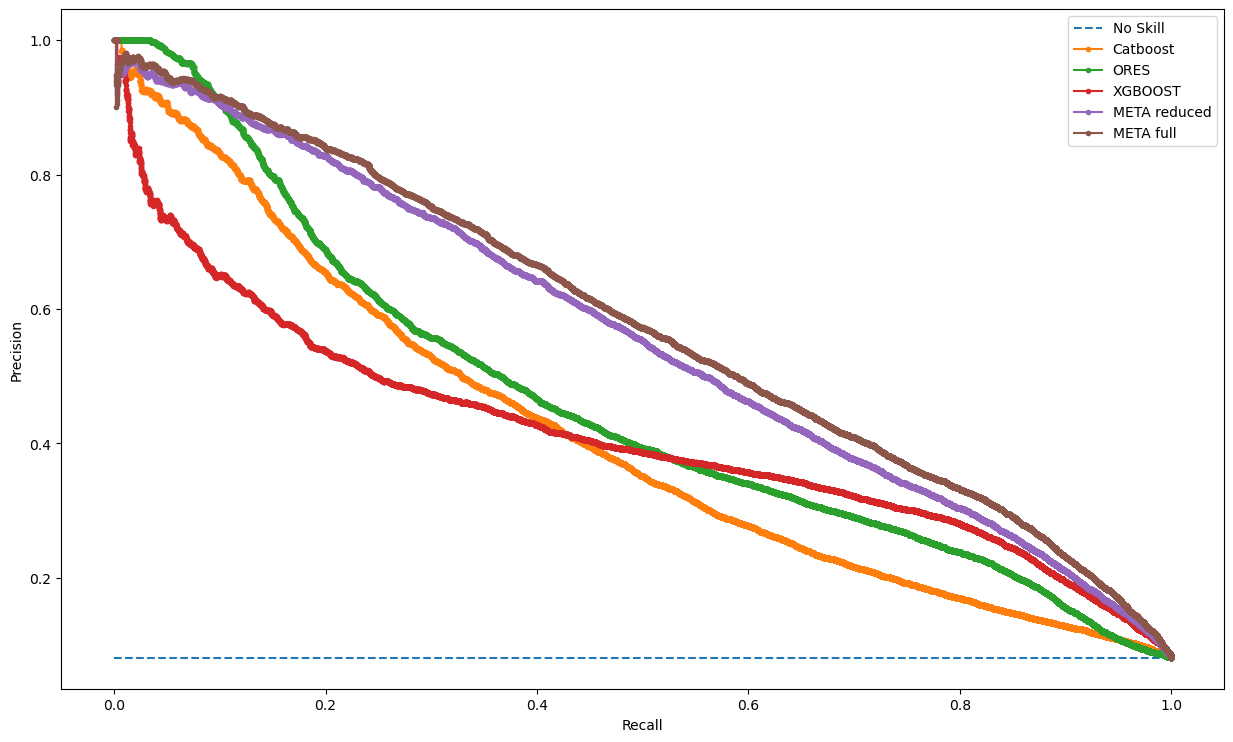

In [102]:
figure(figsize=(15, 9), dpi=100)
precision_recall_plot(test)

In [105]:
pd.DataFrame({'feature_importance': model_full.get_feature_importance(test_data), 
              'feature_names': features_to_use}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(30)

,feature_importance,feature_names
117,16.527786,catboost_pred
120,15.036326,user_revision_count
116,8.390020,xgb_pred
121,5.291204,user_age
0,4.370945,wiki_db
119,4.005790,page_seconds_since_previous_revision
122,3.362081,page_age
118,2.793361,user_groups
115,1.941453,bert_title_score
1,1.821703,revision_text_bytes_diff
